In [ ]:
!pip install transformers datasets accelerate nvidia-ml-py3 numpy bitsandbytes >> /dev/null

We will understand how the GPU is utilized during the training. How the compute intensity varies on the operation performed

**nvidia-ml-py3** provides access to nvidia-smi outputs inside python. 

In [1]:
# dummy data creation
import torch
import numpy as np
from datasets import Dataset

seq_len, dataset_size = 512, 512  # 512 sentences and 512 tokens

dummy_data = {
    "input_ids":np.random.randint(100, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(0, 1, (dataset_size))
}

ds = Dataset.from_dict(dummy_data)
ds.set_format('pt')

In [ ]:
ds

> Facing the error AttributeError: module 'numpy' has no attribute 'object'.

    - Installing numpy did not resolve the issue
    
    - installing pip3 install numpy==1.23.5 
        
        > that threw some compatibility errors in kaggle, and bailed out

In [4]:
# building helper function for looking at GPU usage
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    AutoTokenizer
)
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)  # catch the gpu
    info = nvmlDeviceGetMemoryInfo(handle)  # get memory of the handle
    print(f"GPU Memory used : {info.used // 1024 ** 2} MB")
    
def print_allgpu_utilization():
    nvmlInit()
    handle0 = nvmlDeviceGetHandleByIndex(0)  # catch the gpu
    handle1 = nvmlDeviceGetHandleByIndex(1)  # catch the gpu
    info0 = nvmlDeviceGetMemoryInfo(handle0)  # get memory of the handle
    info1 = nvmlDeviceGetMemoryInfo(handle1)  # get memory of the handle
    print(f"GPU 0 Memory used : {info0.used // 1024 ** 2} MB")
    print(f"GPU 1 Memory used : {info1.used // 1024 ** 2} MB")
    
    
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [3]:
print_allgpu_utilization()

GPU 0 Memory used : 258 MB
GPU 1 Memory used : 258 MB


In [ ]:
tst = torch.ones((1, 1)).to('cuda')
print_gpu_utilization()
print_allgpu_utilization()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased").to('cuda')

model_source = "https://huggingface.co/bert-large-uncased/tree/main"

print_gpu_utilization()

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased",
                                                          device_map="auto",
                                                          pad_token_id=0).to('cuda')
# ValueError: BertForSequenceClassification does not support `device_map='auto'`

In [ ]:
try_codellama = 'codellama/CodeLlama-7b-hf'
llama_source = "https://huggingface.co/codellama/CodeLlama-7b-hf"
# Goes out of memory in 2 X T4. The total model itself is only 14GB.
# Then why OOM?
# model = AutoModelForCausalLM.from_pretrained(try_codellama,
                                             device_map="auto",
                                             pad_token_id=0).to('cuda')


In [ ]:
try_stability = 'stabilityai/stablelm-zephyr-3b'
source = "https://huggingface.co/stabilityai/stablelm-zephyr-3b/tree/main"

model = AutoModelForCausalLM.from_pretrained(try_stability,
                                             device_map="auto", trust_remote_code=True,
                                             pad_token_id=0).to('cuda')


In [ ]:
print_allgpu_utilization()

In [ ]:
try_stability = 'stabilityai/stablelm-zephyr-3b'

# use bfloat16

# Almost all models are trained in bfloat16 nowadays, there is no reason to run the model in
# full float32 precision if your GPU supports bfloat16. Float32 won’t
# give better inference results than the precision that was used to train the model.
model = AutoModelForCausalLM.from_pretrained(try_stability,
                                             device_map="auto",
                                             trust_remote_code=True,
                                             torch_dtype=torch.bfloat16,
                                             pad_token_id=0).to('cuda')


In [ ]:
try_stability = 'stabilityai/stablelm-zephyr-3b'

# use bfloat16, bitsandbytes

model = AutoModelForCausalLM.from_pretrained(try_stability,
                                             device_map="auto",
                                             trust_remote_code=True,
                                             load_in_8bit=True,
                                             pad_token_id=0)

In [ ]:
print_allgpu_utilization()

In [ ]:
model_4bit = AutoModelForCausalLM.from_pretrained(try_stability,
                                             device_map="auto",
                                             trust_remote_code=True,
                                             load_in_4bit=True,
                                             pad_token_id=0)

In [ ]:
print_allgpu_utilization()

In [5]:
octo_tokenizer = AutoTokenizer.from_pretrained("bigcode/octocoder")

tokenizer_config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

In [6]:
octo_model = AutoModelForCausalLM.from_pretrained("bigcode/octocoder",
                                             load_in_4bit=True,
                                             device_map="auto")

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/38.2k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/9.86G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/9.85G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/9.86G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/9.85G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/9.86G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [7]:
print_allgpu_utilization()

GPU 0 Memory used : 4554 MB
GPU 1 Memory used : 5222 MB


In [8]:
system_prompt = """Below are a series of dialogues between various people and an AI technical assistant.
The assistant tries to be helpful, polite, honest, sophisticated, emotionally aware, and humble but knowledgeable.
The assistant is happy to help with code questions and will do their best to understand exactly what is needed.
It also tries to avoid giving false or misleading information, and it caveats when it isn't entirely sure about the right answer.
That said, the assistant is practical really does its best, and doesn't let caution get too much in the way of being useful.

The Starcoder models are a series of 15.5B parameter models trained on 80+ programming languages from The Stack (v1.2) (excluding opt-out requests).
The model uses Multi Query Attention, was trained using the Fill-in-the-Middle objective, and with 8,192 tokens context window for a trillion tokens of heavily deduplicated data.

-----

Question: Write a function that takes two lists and returns a list that has alternating elements from each input list.

Answer: Sure. Here is a function that does that.

def alternating(list1, list2):
   results = []
   for i in range(len(list1)):
       results.append(list1[i])
       results.append(list2[i])
   return results

Question: Can you write some test cases for this function?

Answer: Sure, here are some tests.

assert alternating([10, 20, 30], [1, 2, 3]) == [10, 1, 20, 2, 30, 3]
assert alternating([True, False], [4, 5]) == [True, 4, False, 5]
assert alternating([], []) == []

Question: Modify the function so that it returns all input elements when the lists have uneven length. The elements from the longer list should be at the end.

Answer: Here is the modified function.

def alternating(list1, list2):
   results = []
   for i in range(min(len(list1), len(list2))):
       results.append(list1[i])
       results.append(list2[i])
   if len(list1) > len(list2):
       results.extend(list1[i+1:])
   else:
       results.extend(list2[i+1:])
   return results

-----
"""

In [9]:
input_ids = octo_tokenizer(system_prompt,
                           return_tensors="pt")["input_ids"].to("cuda")

In [10]:
for _ in range(5):
  next_logits = octo_model(input_ids)["logits"][:, -1:]
  next_token_id = torch.argmax(next_logits,dim=-1)

  input_ids = torch.cat([input_ids, next_token_id], dim=-1)
  print("shape of input_ids", input_ids.shape)

/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')
2024-01-31 08:35:27.766363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 08:35:27.766430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 08:35:27.768026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS

shape of input_ids torch.Size([1, 560])
shape of input_ids torch.Size([1, 561])
shape of input_ids torch.Size([1, 562])
shape of input_ids torch.Size([1, 563])
shape of input_ids torch.Size([1, 564])


In [12]:
generated_text = octo_tokenizer.batch_decode(input_ids[:, -5:])
generated_text

['\nAnswer: Sure.']

In [ ]:
torch.cuda.max_memory_allocated() / 1024 ** 2

In [ ]:
del model_4bit
import gc

def flush():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

In [ ]:
flush()
print_allgpu_utilization()

There are various quantization techniques, which we won’t discuss in detail here, but in general, all quantization techniques work as follows:

> Quantize all weights to the target precision

> Load the quantized weights, and pass the input sequence of vectors in bfloat16 precision

> Dynamically dequantize weights to bfloat16 to perform the computation with their input vectors in bfloat16 precision

LLMs usually have multiple attention heads, thus doing multiple self-attention computations in parallel. Assuming, the LLM has 40 attention heads and runs in bfloat16 precision, we can calculate the memory requirement to store the QK^T matrices to be 40 X 2 X N^2. 

For N = 1000 it is 50MB and for N = 16000 it is 19GB


In [ ]:
!nvidia-smi

In [ ]:
# setting standard training args

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none"
}

In [ ]:
from transformers import TrainingArguments, Trainer, logging
logging.set_verbosity_error()

trn_args = TrainingArguments(per_device_train_batch_size=4,
                             **default_args)

In [ ]:
trainer = Trainer(model=model,
                  args=trn_args,
                  train_dataset=ds)

In [ ]:
result = trainer.train()

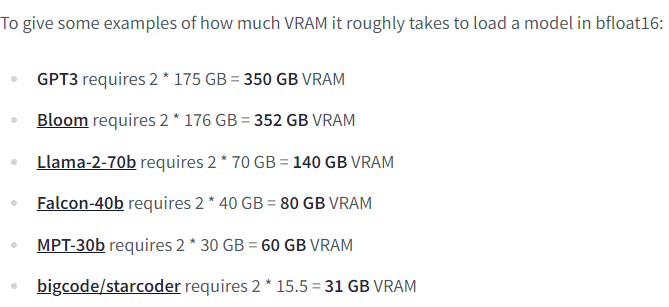

### Three main groups of operations

1. Tensor Contractions: (Most compute intensive)
    
    Linear Layer and components of multi-head attention do batched matrix-matrix multiplications. 
    
2. Stat Normalisation: (less intensive than 1)
    
    softmax / layer normalisation, which involve one or more reductive ops

3. Element-wise operators:

    biases, dropouts, activations & residual connections, all are element-wise operations, and require lesser compute

### This is because there are many components during training that use GPU memory. 

The components on GPU memory are the following:

1. Model Weights  : 4B * no. of.param (fp32)
                    6B * no. of.param (mixed prec)
                    
2. Optimizer states: 8B * no. of.param for normal AdamW(maintains 2 states)
                     2B * no. of.param for 8-bit AdamW(bnb)
                     4B * no. of.param for SGD like optimizer
                     
3. Gradients       : 4B * no. of.param for fp32 / mixed precision

4. Forward Activation: Depends on seq_len, hidden_size, batch_size

5. Temporary Memory : Other kinds of Memory that can push to OOM

6. Functional Memory: Software might require memory for doing some operations

> backward compute takes 2x flops compared to the forward, as the backward is more complex. Activation is bandwidth constrained, as it reads more data in backward pass. 

There are **two important** components of the model architecture that quickly become memory and/or performance bottlenecks for large input sequences.

> The positional embeddings

> The key-value cache

### Positional Embedding

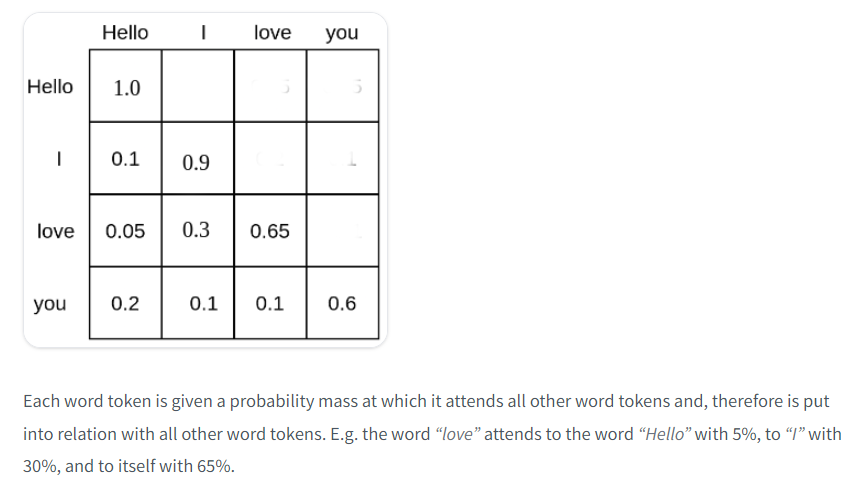


> For long text inputs, it is advantageous if the model learns the relative positional distance input tokens have to each other instead of their absolute position.


> Another issue in learned position embeddings, the LLM has to be trained on a fixed input length N, which makes it difficult to extrapolate to an input length longer than what it was trained on.

**RoPE** is used in multiple of today’s most important LLMs, such as:

- Falcon

- Llama

- PaLM

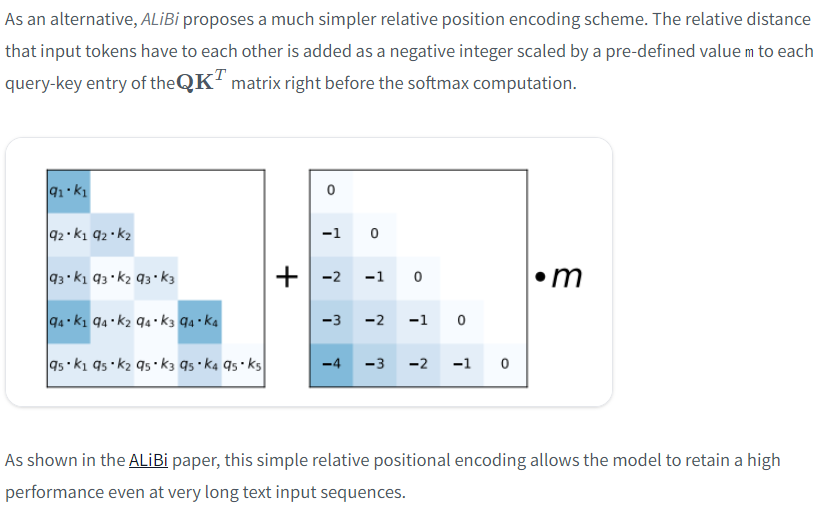


**ALiBi** is used in multiple of today’s most important LLMs, such as:

- MPT

- BLOOM

In [13]:
# Using the K-V cache in operation

"""
One should always make use of the key-value cache as it leads to identical results and 
a significant speed-up for longer input sequences. Transformers has the key-value cache
enabled by default when making use of the text pipeline or the generate method.
"""

past_key_values = None # past_key_values is the key-value cache
generated_tokens = []
next_token_id = octo_tokenizer(system_prompt,
                               return_tensors="pt")["input_ids"].to("cuda")

In [14]:
for _ in range(5):
  next_logits, past_key_values = octo_model(next_token_id,
                                            past_key_values=past_key_values,
                                            use_cache=True).to_tuple()
  next_logits = next_logits[:, -1:]
  next_token_id = torch.argmax(next_logits, dim=-1)

  print("shape of input_ids", next_token_id.shape)
    
  print("length of key-value cache", len(past_key_values[0][0]))  # past_key_values are of shape [num_layers, 0 for k, 1 for v, batch_size, length, hidden_dim]
  generated_tokens.append(next_token_id.item())
    
# length of KV-Cache is increased

shape of input_ids torch.Size([1, 1])
length of key-value cache 559
shape of input_ids torch.Size([1, 1])
length of key-value cache 560
shape of input_ids torch.Size([1, 1])
length of key-value cache 561
shape of input_ids torch.Size([1, 1])
length of key-value cache 562
shape of input_ids torch.Size([1, 1])
length of key-value cache 563


In [16]:
generated_text = octo_tokenizer.batch_decode(generated_tokens)
generated_text

['\n', 'Answer', ':', ' Sure', '.']

In [17]:
# Generation as usual
prompt = system_prompt + "Question: Please write a function in Python that transforms bytes to Giga bytes.\n\nAnswer: Here"

model_inputs = octo_tokenizer(prompt, return_tensors='pt')

In [18]:
generation_output = octo_model.generate(**model_inputs,
                                   max_new_tokens=60,
                                   return_dict_in_generate=True)
decoded_output = octo_tokenizer.batch_decode(generation_output.sequences)[0]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1408: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [21]:
print(decoded_output)

Below are a series of dialogues between various people and an AI technical assistant.
The assistant tries to be helpful, polite, honest, sophisticated, emotionally aware, and humble but knowledgeable.
The assistant is happy to help with code questions and will do their best to understand exactly what is needed.
It also tries to avoid giving false or misleading information, and it caveats when it isn't entirely sure about the right answer.
That said, the assistant is practical really does its best, and doesn't let caution get too much in the way of being useful.

The Starcoder models are a series of 15.5B parameter models trained on 80+ programming languages from The Stack (v1.2) (excluding opt-out requests).
The model uses Multi Query Attention, was trained using the Fill-in-the-Middle objective, and with 8,192 tokens context window for a trillion tokens of heavily deduplicated data.

-----

Question: Write a function that takes two lists and returns a list that has alternating element

In [22]:
# Piping the returned `past_key_values` to speed up the next conversation round
prompt = decoded_output + "\nQuestion: How can I modify the function above to return Mega bytes instead?\n\nAnswer: Here"

model_inputs = octo_tokenizer(prompt, return_tensors='pt')

generation_output = octo_model.generate(
  **model_inputs,
  past_key_values=generation_output.past_key_values,
  max_new_tokens=60,
  return_dict_in_generate=True
)

octo_tokenizer.batch_decode(generation_output.sequences)[0][len(prompt):]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1408: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


' is a modified version of the function that returns Mega bytes instead.\n\ndef bytes_to_megabytes(bytes):\n   return bytes / 1024 / 1024\n\nAnswer: The function takes a number of bytes as input and returns the number of'

**Multi-Query-Attention (MQA):**

Instead of using n_head key-value projections weights, one can use a single head-value projection weight pair that is shared across all attention heads without that the model’s performance significantly degrades.

LLM used in this notebook we could therefore reduce the required memory consumption from 15 GB to less than 400 MB at an input sequence length of 16000.

MQA has seen wide adoption by the community and is now used by many of the most popular LLMs:

- Falcon

- PaLM

- MPT

- BLOOM

**Group Query Attention:**

GQA argues that more model performance can be kept by less drastically reducing the number of query head projection weights. Instead of using just a single key-value projection weight, n < n_head key-value projection weights should be used. 

By choosing n to a significantly smaller value than n_head, such as 2,4 or 8 almost all of the memory and speed gains from MQA can be kept while sacrificing less model capacity and thus arguably less performance.